In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, silhouette_score

In [3]:
dataframe_full_features = pd.read_csv("../data/Cornescu_Darius_new_features.csv")
dataframe_selected_features = pd.read_csv("../data/Cornescu_Darius_selected_features.csv")


In [4]:
dataframe_full_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          1168 non-null   int64  
 1   MSZoning            1168 non-null   object 
 2   LotFrontage         951 non-null    float64
 3   LotArea             1168 non-null   int64  
 4   Street              1168 non-null   object 
 5   Alley               74 non-null     object 
 6   LotShape            1168 non-null   object 
 7   LandContour         1168 non-null   object 
 8   Utilities           1168 non-null   object 
 9   LotConfig           1168 non-null   object 
 10  LandSlope           1168 non-null   object 
 11  Neighborhood        1168 non-null   object 
 12  Condition1          1168 non-null   object 
 13  Condition2          1168 non-null   object 
 14  SalePrice           1168 non-null   int64  
 15  LotArea_m^2         1168 non-null   float64
 16  Price_

In [5]:
dataframe_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SalePrice          1168 non-null   int64  
 1   LotFrontage        1168 non-null   float64
 2   ZoningScore        1168 non-null   float64
 3   EVI                1168 non-null   float64
 4   LotArea            1168 non-null   int64  
 5   Price_per_m^2      1168 non-null   float64
 6   PDI                1168 non-null   float64
 7   MSZoning_RL        1168 non-null   bool   
 8   LotConfig_CulDSac  1168 non-null   bool   
 9   LandContour_HLS    1168 non-null   bool   
 10  LotShape_IR2       1168 non-null   bool   
 11  Condition1_Norm    1168 non-null   bool   
 12  MSZoning_FV        1168 non-null   bool   
 13  Condition1_Feedr   1168 non-null   bool   
 14  LotShape_Reg       1168 non-null   bool   
 15  MSZoning_RM        1168 non-null   bool   
dtypes: bool(9), float64(5), 

In [6]:
def make_preprocessor(dataframe):
    numeric_features = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = dataframe.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))
    ])

    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor

In [7]:
X = dataframe_full_features.drop(columns=["SalePrice"])
Y = dataframe_full_features["SalePrice"]

preprocessor = make_preprocessor(X)
X_processed = preprocessor.fit_transform(X)
X_processed_dense = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed_dense)

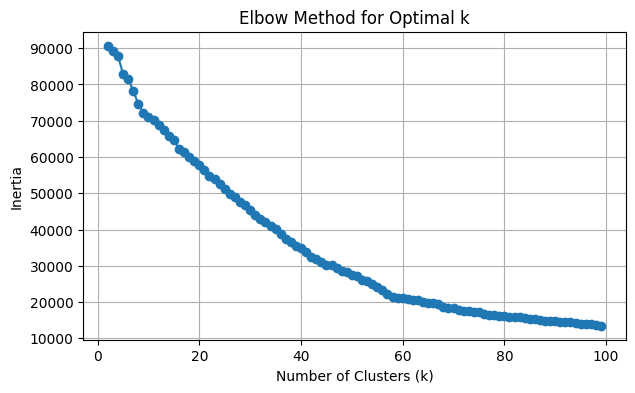

In [8]:
inertia = []
K = range(2, 100)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [9]:
X = dataframe_selected_features.drop(columns=["SalePrice"])
Y = dataframe_selected_features["SalePrice"]

preprocessor = make_preprocessor(X)
X_processed = preprocessor.fit_transform(X)
X_processed_dense = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed_dense)

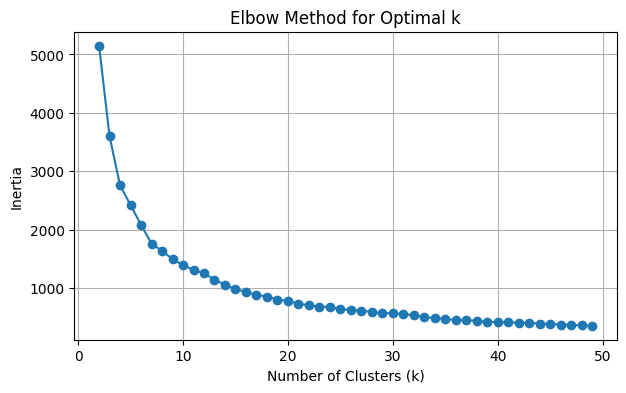

In [10]:
inertia = []
K = range(2, 50)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


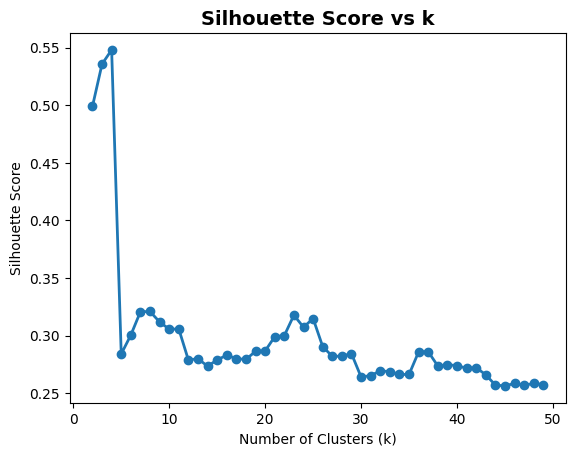

In [11]:
silhouette_scores = []
K_range = range(2, 50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2)
plt.title("Silhouette Score vs k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [12]:
top_k_values = sorted(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i], reverse=True)[:10]
for idx in top_k_values:
    print(f"Top k: {K_range[idx]} with Silhouette Score: {silhouette_scores[idx]:.4f}")

Top k: 4 with Silhouette Score: 0.5480
Top k: 3 with Silhouette Score: 0.5357
Top k: 2 with Silhouette Score: 0.4989
Top k: 8 with Silhouette Score: 0.3209
Top k: 7 with Silhouette Score: 0.3207
Top k: 23 with Silhouette Score: 0.3178
Top k: 25 with Silhouette Score: 0.3149
Top k: 9 with Silhouette Score: 0.3118
Top k: 24 with Silhouette Score: 0.3073
Top k: 11 with Silhouette Score: 0.3057


In [13]:
def create_smart_bins_7_classes(dataframe):
    """
    Combine related price ranges into 7 classes:
        budget --- 34.9K - 120K (very_cheap + cheap)
        affordable --- 120K - 160K (affordable + medium_low)
        medium --- 160K - 200K (medium + medium_high)
        expensive --- 200K - 235K
        very_expensive --- 235K - 285K
        luxury --- 285K - 400K
        ultra_luxury --- 400K+
    """
    prices = dataframe['SalePrice']
    custom_bins = [
        34900,  
        115000,     
        160000,    
        205000,     
        235000,     
        285000,     
        400000,     
        745001     
    ]

    labels = ['budget', 'affordable', 'medium', 'expensive', 'very_expensive', 'luxury', 'ultra_luxury']

    price_groups = pd.cut(prices, bins=custom_bins, labels=labels, include_lowest=True)
    distribution = price_groups.value_counts().sort_index()
    
    print("\nIntervale și count-uri (7 classes):")
    for i, (label, count) in enumerate(zip(labels, distribution)):
        print(f"{label:20s} [{custom_bins[i]:>8,.0f} - {custom_bins[i+1]:>8,.0f}]: {count:4d} case")
    
    return custom_bins, labels

custom_bins_7, custom_labels_7 = create_smart_bins_7_classes(dataframe_selected_features)


Intervale și count-uri (7 classes):
budget               [  34,900 -  115,000]:  169 case
affordable           [ 115,000 -  160,000]:  386 case
medium               [ 160,000 -  205,000]:  287 case
expensive            [ 205,000 -  235,000]:  115 case
very_expensive       [ 235,000 -  285,000]:  107 case
luxury               [ 285,000 -  400,000]:   83 case
ultra_luxury         [ 400,000 -  745,001]:   21 case


In [14]:
def bin_prices(Y_train, Y_test, method="qcut", number_bins=5, custom_bins=None, custom_labels=None, n_clusters=7, random_state=42):
    """Convert continuous prices to class labels."""
    if method == "custom":
        y_train = pd.cut(Y_train, bins=custom_bins, labels=custom_labels, include_lowest=True)
        y_test = pd.cut(Y_test, bins=custom_bins, labels=custom_labels, include_lowest=True)

        if isinstance(custom_labels[0], str):
            return y_train, y_test
        else:
            return pd.Series(y_train).astype(int), pd.Series(y_test).astype(int)
        
        
    elif method == "qcut":
        q_edges = np.unique(np.quantile(Y_train, q=np.linspace(0, 1, number_bins + 1)))
        y_train = pd.cut(Y_train, bins=q_edges, labels=range(len(q_edges)-1), include_lowest=True)
        y_test = pd.cut(Y_test, bins=q_edges, labels=range(len(q_edges)-1), include_lowest=True)
        
    elif method == "kmeans":
        km = KMeans(n_clusters=n_clusters, random_state=random_state)
        km.fit(Y_train.reshape(-1, 1))
        
        centers = km.cluster_centers_.flatten()
        order = np.argsort(centers)
        remap = {old: new for new, old in enumerate(order)}
        
        y_train = np.vectorize(remap.get)(km.predict(Y_train.reshape(-1, 1)))
        y_test = np.vectorize(remap.get)(km.predict(Y_test.reshape(-1, 1)))
        
    return pd.Series(y_train).astype(int), pd.Series(y_test).astype(int)

In [15]:
def print_class_distribution(y_train, y_test, n_classes):
    def get_counts(y, k):
        counts = pd.Series(y).value_counts().sort_index().reindex(range(k), fill_value=0)
        perc = (counts / counts.sum() * 100).round(2)
        return counts, perc
    
    train_counts, train_perc = get_counts(y_train, n_classes)
    test_counts, test_perc = get_counts(y_test, n_classes)
    
    print("\nClass distribution (TRAIN):")
    print(pd.DataFrame({"count": train_counts, "percent": train_perc}))
    print("\nClass distribution (TEST):")
    print(pd.DataFrame({"count": test_counts, "percent": test_perc}))


In [16]:
def train_random_forest(X_train, X_test, y_train, y_test, random_state=42):
    preprocessor = make_preprocessor(X_train)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\n", classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.show()
    
    return pipe, {'accuracy': accuracy, 'f1': f1, 'precision': precision}


In [17]:
def train_decision_tree(X_train, X_test, y_train, y_test, random_state=42):
    preprocessor = make_preprocessor(X_train)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\n", classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.show()
    
    return pipe, {'accuracy': accuracy, 'f1': f1, 'precision': precision}

In [20]:
def compare_binning_methods(dataframe, methods=["qcut", "kmeans", "custom"], number_bins=7, custom_bins=None, custom_labels=None, n_clusters=7, random_state=42, tree_type="random_forest"):
    X = dataframe.drop(columns=["SalePrice"])
    Y = dataframe["SalePrice"].astype(float).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    
    results = {}
    comparison_data = []
    
    for method in methods:
        print(f"\n{'='*60}")
        print(f"METHOD: {method.upper()}")
        print('='*60)
        
        y_train, y_test = bin_prices(Y_train, Y_test, method=method, number_bins=number_bins, 
                                      custom_bins=custom_bins, custom_labels=custom_labels, 
                                      n_clusters=n_clusters, random_state=random_state)
        
        print_class_distribution(y_train, y_test, n_clusters if method=="kmeans" else number_bins)
        
        if tree_type == "decision_tree":
            pipe, metrics = train_decision_tree(X_train, X_test, y_train, y_test, random_state)
        else:
            pipe, metrics = train_random_forest(X_train, X_test, y_train, y_test, random_state)
        
        results[method] = pipe
        comparison_data.append({
            'Method': method,
            'Accuracy': metrics['accuracy'],
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\n{'='*60}")
    print("COMPARISON TABLE")
    print('='*60)
    print(comparison_df.to_string(index=False))
    
    return results, comparison_df


METHOD: QCUT

Class distribution (TRAIN):
   count  percent
0    235    25.16
1    232    24.84
2    233    24.95
3    234    25.05

Class distribution (TEST):
   count  percent
0     61    26.07
1     52    22.22
2     56    23.93
3     65    27.78
Accuracy:  0.8547
F1 Score:  0.8551
Precision: 0.8578

               precision    recall  f1-score   support

           0       0.88      0.92      0.90        61
           1       0.80      0.77      0.78        52
           2       0.79      0.86      0.82        56
           3       0.95      0.86      0.90        65

    accuracy                           0.85       234
   macro avg       0.85      0.85      0.85       234
weighted avg       0.86      0.85      0.86       234



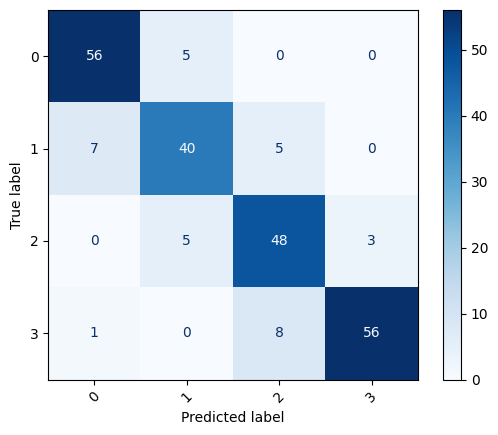


METHOD: KMEANS

Class distribution (TRAIN):
   count  percent
0    445    47.64
1    336    35.97
2    119    12.74
3     34     3.64

Class distribution (TEST):
   count  percent
0    110    47.01
1     79    33.76
2     37    15.81
3      8     3.42
Accuracy:  0.8761
F1 Score:  0.8736
Precision: 0.8834

               precision    recall  f1-score   support

           0       0.95      0.95      0.95       110
           1       0.78      0.91      0.84        79
           2       0.89      0.65      0.75        37
           3       1.00      0.62      0.77         8

    accuracy                           0.88       234
   macro avg       0.90      0.78      0.83       234
weighted avg       0.88      0.88      0.87       234



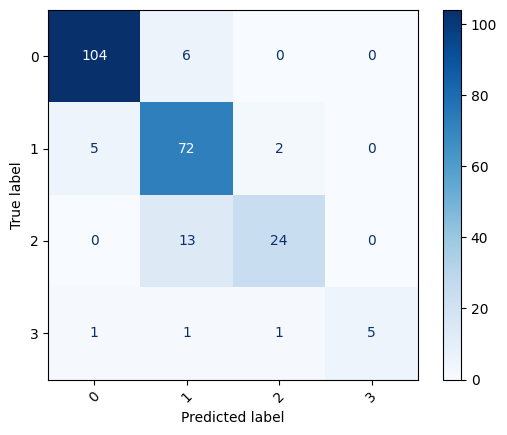


COMPARISON TABLE
Method  Accuracy  F1 Score  Precision
  qcut  0.854701  0.855123   0.857844
kmeans  0.876068  0.873633   0.883397


In [72]:
results, comparison = compare_binning_methods(
    dataframe_selected_features,
    methods=["qcut", "kmeans"],
    number_bins=4,
    custom_bins=custom_bins_7,
    custom_labels=custom_labels_7,
    n_clusters=4,
    random_state=42, 
    tree_type="random_forest"
)

## Optiune alternativă: Etichetarea folosind K-Means

In [34]:
print("\nColoanele disponibile:")
print(dataframe_selected_features.columns.tolist())
print("Primele rânduri din dataset:")
dataframe_selected_features.head()


Coloanele disponibile:
['SalePrice', 'LotFrontage', 'ZoningScore', 'EVI', 'LotArea', 'Price_per_m^2', 'PDI', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'MSZoning_FV', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']
Primele rânduri din dataset:


,SalePrice,LotFrontage,ZoningScore,EVI,LotArea,Price_per_m^2,PDI,MSZoning_RL,LotConfig_CulDSac,LandContour_HLS,LotShape_IR2,Condition1_Norm,MSZoning_FV,Condition1_Feedr,LotShape_Reg,MSZoning_RM
0,145000,70.0,0.795605,0.344162,8400,185.805676,0.359777,True,False,False,False,True,False,False,True,False
1,178000,59.0,0.795605,0.415263,7837,244.478356,0.422145,True,False,False,False,True,False,False,False,False
2,85000,67.0,0.795605,0.314380,8777,104.242085,0.376095,True,False,False,False,False,False,True,True,False
3,175000,60.0,0.795605,0.413210,7200,261.622935,0.405462,True,False,False,False,False,False,True,True,False
4,127000,50.0,0.795605,0.419031,5000,273.403442,0.402378,True,False,False,False,True,False,False,True,False


In [63]:
X = dataframe_selected_features.drop(columns=["SalePrice"])
Y = dataframe_selected_features["SalePrice"]

n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=42)
km.fit(Y.values.reshape(-1,1))

labels = km.predict(Y.values.reshape(-1, 1))

df_clusters = pd.DataFrame({
    'SalePrice': Y,
    'label':labels
})


In [64]:
cluster_means = df_clusters.groupby("label")["SalePrice"].mean()
print("\nMedia prețului pentru fiecare cluster:")
print(cluster_means.to_frame().rename(columns={'SalePrice': 'Mean SalePrice'}))


Media prețului pentru fiecare cluster:
       Mean SalePrice
label                
0       274708.236559
1       121689.474206
2       427613.953488
3       186457.687356


In [65]:
df_result = dataframe_selected_features.copy()
df_result['label'] = labels

df_features_with_labels = df_result.drop(columns=['SalePrice'])
print(df_features_with_labels.head())
print(f"\nShape: {df_features_with_labels.shape}")

df_features_with_labels.to_csv("../data/subset_classification_Cornescu_Darius.csv", index=False)

   LotFrontage  ZoningScore       EVI  LotArea  Price_per_m^2       PDI  \
0         70.0     0.795605  0.344162     8400     185.805676  0.359777   
1         59.0     0.795605  0.415263     7837     244.478356  0.422145   
2         67.0     0.795605  0.314380     8777     104.242085  0.376095   
3         60.0     0.795605  0.413210     7200     261.622935  0.405462   
4         50.0     0.795605  0.419031     5000     273.403442  0.402378   

   MSZoning_RL  LotConfig_CulDSac  LandContour_HLS  LotShape_IR2  \
0         True              False            False         False   
1         True              False            False         False   
2         True              False            False         False   
3         True              False            False         False   
4         True              False            False         False   

   Condition1_Norm  MSZoning_FV  Condition1_Feedr  LotShape_Reg  MSZoning_RM  \
0             True        False             False          T

Accuracy:  0.8462
F1 Score:  0.8445
Precision: 0.8460

               precision    recall  f1-score   support

           0       0.83      0.68      0.75        37
           1       0.89      0.91      0.90       101
           2       0.67      0.67      0.67         9
           3       0.82      0.86      0.84        87

    accuracy                           0.85       234
   macro avg       0.80      0.78      0.79       234
weighted avg       0.85      0.85      0.84       234



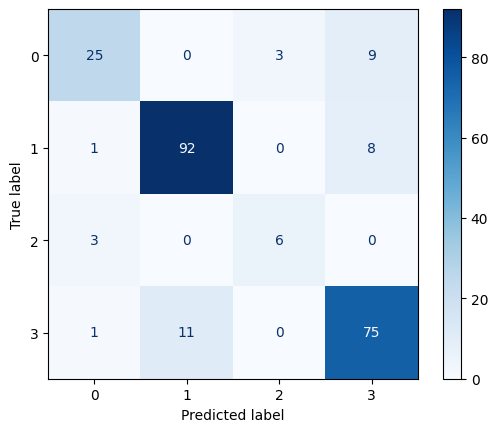

In [66]:
df_loaded = pd.read_csv("../data/subset_classification_Cornescu_Darius.csv")
X = df_loaded.drop(columns=['label'])
Y = df_loaded['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

preprocessor_decision_tree = make_preprocessor(X_train)
pipeline_dt = Pipeline([ 
    ('preprocessor', preprocessor_decision_tree),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_dt.fit(X_train, Y_train)
Y_predicted_dt = pipeline_dt.predict(X_test)

accuracy_score_dt = accuracy_score(Y_test, Y_predicted_dt)
f1_dt = f1_score(Y_test, Y_predicted_dt, average='weighted')
prec_dt = precision_score(Y_test, Y_predicted_dt, average='weighted')

print(f"Accuracy:  {accuracy_score_dt:.4f}")
print(f"F1 Score:  {f1_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print("\n", classification_report(Y_test, Y_predicted_dt))

cm_dt = confusion_matrix(Y_test, Y_predicted_dt)
ConfusionMatrixDisplay(cm_dt).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy:  0.8504
F1 Score:  0.8490
Precision: 0.8570

               precision    recall  f1-score   support

           0       0.84      0.70      0.76        37
           1       0.92      0.90      0.91       101
           2       1.00      0.56      0.71         9
           3       0.78      0.89      0.83        87

    accuracy                           0.85       234
   macro avg       0.88      0.76      0.80       234
weighted avg       0.86      0.85      0.85       234



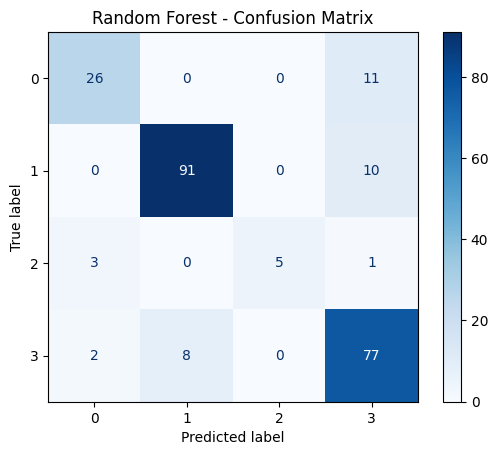

In [67]:
preprocessor_rf = make_preprocessor(X_train)
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, Y_train)
Y_predicted_rf = pipeline_rf.predict(X_test)

acc_rf = accuracy_score(Y_test, Y_predicted_rf)
f1_rf = f1_score(Y_test, Y_predicted_rf, average='weighted')
prec_rf = precision_score(Y_test, Y_predicted_rf, average='weighted')

print(f"Accuracy:  {acc_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print("\n", classification_report(Y_test, Y_predicted_rf))

cm_rf = confusion_matrix(Y_test, Y_predicted_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap=plt.cm.Blues)
plt.title("Random Forest - Confusion Matrix")
plt.show()

**Care dintre cele două modele performează mai bine?**

Random Forest obține valori ușor mai mari pentru **accuracy (0.8504 vs 0.8462)** și **F1-Score (0.8490 vs 0.8445)** comparativ cu Decision Tree.
Deși diferența este mică, Random Forest este **per ansamblu mai stabil** și generalizează mai bine.

---

**Comparație cu laboratorul precedent**

Deși în acest laborator etichetarea a fost realizată printr-o metodă custom, iar în laboratorul precedent împărțirea a fost efectuată prin **QCUT**, performanțele obținute rămân **foarte apropiate**.

| Metodă (Lab precedent)   | Accuracy   | F1-Score   |                                                             |
| ------------------------ | ---------- | ---------- | ---------------------------------------------------------------------- |
| QCUT (clase echilibrate) | **0.8547** | **0.8551** | Performanță stabilă datorată distribuției uniforme                     |
| K-Means (mapare pret)    | **0.8761** | **0.8736** | Mai bun pe clase mari, dar clase mici greu de distins                  |
| **Metoda actuală**       | **0.8504** | **0.8490** | Rezultate apropiate, în unele zone chiar superioare pe clase dominante |

**Concluzie:** Metoda curentă obține performanțe **comparabile** cu abordările anterioare, confirmând că modelul surprinde corect relația dintre trăsături și preț, indiferent de strategia de etichetare.


